<a href="https://colab.research.google.com/github/rchennau/scripts/blob/main/SDXL_DreamBooth_LoRA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check the GPU
!nvidia-smi

Sun Jun  2 16:00:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.9 MB/s eta 0:00:00


Make sure to install `diffusers` from `main`.

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git -q
!pip install torch
!pip install datasets
!pip install xformers -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━

Download diffusers SDXL DreamBooth training script.

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-06-03 15:20:01--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84311 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py.1’

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.002s  

2024-06-03 15:20:01 (33.2 MB/s) - ‘train_dreambooth_lora_sdxl.py.1’ saved [84311/84311]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.



**Option 1:** upload example images from your local files:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import os
from google.colab import files

# pick a name for the image folder
local_dir = "/content/drive/MyDrive/training-set/srcy_v4/data" #@param
#os.makedirs(local_dir)
os.chdir(local_dir)

# choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

**Option 2:** download example images from the hub:

In [ ]:
from huggingface_hub import snapshot_download
repo_id = "PostWonder/srcy_v4" #@param
local_dir = "/content/drive/MyDrive/training-set/srcy_v4" #@param
snapshot_download(
    repo_id,
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 44 files:   0%|          | 0/44 [00:00<?, ?it/s]

'/content/drive/MyDrive/training-set/srcy_v4'

Preview the images:

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

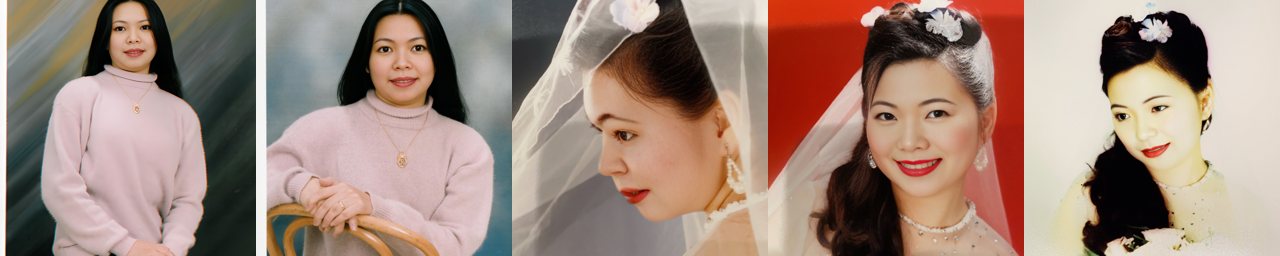

In [ ]:
import glob

# change path to display images from your local dir
img_paths="/content/drive/MyDrive/training-set/srcy_v4/*.png" #@param


imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [ ]:
!pip install transformers
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption


NameError: name '_C' is not defined

In [ ]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "/content/drive/MyDrive/training-set/srcy_v4/" #@param
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.png")]

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [ ]:
import requests
import glob
from transformers import BlipProcessor, BlipForConditionalGeneration
from datasets import Dataset, Image
from huggingface_hub import HfApi, HfFolder
import torch
import PIL
from tqdm import tqdm  # Import tqdm for progress bar

# Load the BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
caption_prefix = "photo of a srcy petite woman,"
repo_id = "PostWonder/srcy_v5"  # Use your actual repo ID
# Image paths
img_path = "/content/drive/MyDrive/training-set/srcy_v4/*.png"
image_paths = glob.glob(img_path)  # Use glob to get a list of files

# Generate captions and create dataset dictionary
data = {"image": [], "prompt": []}
for image_path in tqdm(image_paths, desc="Generating Captions"): # Add progress bar
    raw_image = PIL.Image.open(image_path).convert("RGB")

    # Conditional image captioning
    inputs = processor(raw_image, return_tensors="pt")
    with torch.no_grad():
        out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)

    full_prompt = caption_prefix + caption  # Concatenate prefix and caption
    print(f"Adding prompt to dataset: {full_prompt}")  # Display full prompt

    data["image"].append(raw_image)
    data["prompt"].append(full_prompt)  # Append full prompt

# Create Hugging Face dataset
dataset = Dataset.from_dict(data)

# Upload the dataset to the Hub (replace placeholders)
#repo_id = "your-username/your-dataset-name"  # Use your actual repo ID
dataset.push_to_hub(repo_id)
print(f"Metadata file uploaded to {repo_id}")


Generating Captions:   0%|          | 0/42 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Generating Captions:   2%|▏         | 1/42 [00:00<00:37,  1.10it/s]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a pink sweater


Generating Captions:   5%|▍         | 2/42 [00:02<00:41,  1.03s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a pink sweater and a wooden chair


Generating Captions:   7%|▋         | 3/42 [00:03<00:42,  1.09s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman wearing a veil and a flower in her hair


Generating Captions:  10%|▉         | 4/42 [00:04<00:39,  1.03s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a wedding dress and veil


Generating Captions:  12%|█▏        | 5/42 [00:05<00:36,  1.00it/s]

Adding prompt to dataset: photo of a srcy petite woman,a woman with a flower in her hair


Generating Captions:  14%|█▍        | 6/42 [00:06<00:35,  1.02it/s]

Adding prompt to dataset: photo of a srcy petite woman,a woman standing in front of a fence


Generating Captions:  17%|█▋        | 7/42 [00:07<00:34,  1.02it/s]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a white dress holding a bouquet


Generating Captions:  19%|█▉        | 8/42 [00:08<00:34,  1.02s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a pink sweater posing for a photo


Generating Captions:  21%|██▏       | 9/42 [00:09<00:33,  1.01s/it]

Adding prompt to dataset: photo of a srcy petite woman,a girl sitting on a couch with a dog


Generating Captions:  24%|██▍       | 10/42 [00:10<00:32,  1.03s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a bed holding a dog


Generating Captions:  26%|██▌       | 11/42 [00:11<00:36,  1.18s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch holding a dog


Generating Captions:  29%|██▊       | 12/42 [00:12<00:36,  1.20s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a white dress and a flower in her hair


Generating Captions:  31%|███       | 13/42 [00:14<00:33,  1.17s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a pink sweater posing for a picture


Generating Captions:  33%|███▎      | 14/42 [00:15<00:31,  1.14s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman wearing a hat with a flower on it


Generating Captions:  36%|███▌      | 15/42 [00:16<00:29,  1.10s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a white dress holding a bouquet


Generating Captions:  38%|███▊      | 16/42 [00:17<00:27,  1.07s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a wedding dress with a veil


Generating Captions:  40%|████      | 17/42 [00:18<00:26,  1.07s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a pink sweater posing for a photo


Generating Captions:  43%|████▎     | 18/42 [00:19<00:25,  1.06s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch holding a dog


Generating Captions:  45%|████▌     | 19/42 [00:20<00:24,  1.07s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman wearing a white hat with a pearl necklace


Generating Captions:  48%|████▊     | 20/42 [00:21<00:23,  1.07s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a pink sweater posing for a photo


Generating Captions:  50%|█████     | 21/42 [00:22<00:23,  1.12s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a pink sweater posing for a picture


Generating Captions:  52%|█████▏    | 22/42 [00:24<00:24,  1.25s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a pink sweater and a wooden chair


Generating Captions:  55%|█████▍    | 23/42 [00:25<00:22,  1.20s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a white dress sitting on a bed


Generating Captions:  57%|█████▋    | 24/42 [00:26<00:20,  1.14s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch with a dog


Generating Captions:  60%|█████▉    | 25/42 [00:27<00:17,  1.06s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a red jacket


Generating Captions:  62%|██████▏   | 26/42 [00:28<00:16,  1.03s/it]

Adding prompt to dataset: photo of a srcy petite woman,a man and woman posing for a picture


Generating Captions:  64%|██████▍   | 27/42 [00:29<00:15,  1.02s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch with a dog


Generating Captions:  67%|██████▋   | 28/42 [00:30<00:14,  1.03s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch holding a dog


Generating Captions:  69%|██████▉   | 29/42 [00:31<00:13,  1.04s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch holding a dog


Generating Captions:  71%|███████▏  | 30/42 [00:32<00:12,  1.05s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a pink sweater posing for a photo


Generating Captions:  74%|███████▍  | 31/42 [00:33<00:10,  1.02it/s]

Adding prompt to dataset: photo of a srcy petite woman,a man and woman standing together


Generating Captions:  76%|███████▌  | 32/42 [00:34<00:10,  1.02s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch with a dog


Generating Captions:  79%|███████▊  | 33/42 [00:35<00:09,  1.09s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch with a dog


Generating Captions:  81%|████████  | 34/42 [00:36<00:09,  1.15s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch holding a dog


Generating Captions:  83%|████████▎ | 35/42 [00:37<00:07,  1.12s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch with a dog


Generating Captions:  86%|████████▌ | 36/42 [00:38<00:06,  1.13s/it]

Adding prompt to dataset: photo of a srcy petite woman,a man and woman in formal attire posing for a picture


Generating Captions:  88%|████████▊ | 37/42 [00:39<00:05,  1.07s/it]

Adding prompt to dataset: photo of a srcy petite woman,a man and woman posing for a picture


Generating Captions:  90%|█████████ | 38/42 [00:40<00:04,  1.07s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a wedding dress with a veil


Generating Captions:  93%|█████████▎| 39/42 [00:42<00:03,  1.12s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman wearing a veil and a flower in her hair


Generating Captions:  95%|█████████▌| 40/42 [00:43<00:02,  1.05s/it]

Adding prompt to dataset: photo of a srcy petite woman,a couple sitting in a chair


Generating Captions:  98%|█████████▊| 41/42 [00:44<00:01,  1.06s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman sitting on a couch with a dog


Generating Captions: 100%|██████████| 42/42 [00:45<00:00,  1.08s/it]

Adding prompt to dataset: photo of a srcy petite woman,a woman in a wedding dress sitting on a chair


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Metadata file uploaded to PostWonder/srcy_v5


Free some memory:

In [ ]:
import gc

# delete the BLIP pipelines and free up some memory
#del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [ ]:
!pip install xformers -q
torch.cuda.empty_cache()


NameError: name 'torch' is not defined

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [ ]:
#!/usr/bin/env bash
#  --instance_data_dir="/content/drive/MyDrive/training-set/srcy_v4/" \
#  --instance_prompt="a photo of a srcy2 woman" \
#   --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \

!accelerate launch train_dreambooth_lora_sdxl.py \
  --dataset_name="PostWonder/srcy_v5" \
  --caption_column="prompt" \
  --instance_prompt="photo of a srcy woman" \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --pretrained_model_name_or_path="RunDiffusion/Juggernaut-X-v10" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --resolution="1024" \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --use_8bit_adam \
  --max_train_steps=1200 \
  --checkpointing_steps=717 \
  --seed="0" \
  --output_dir="/content/drive/MyDrive/models/srcy_v4" \
  --output_kohya_format \
  --enable_xformers_memory_efficient_attention \
  --local_rank=128



/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-06-03 04:06:18.149470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 04:06:18.149515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 04:06:18.150712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] 

### Save your model to the hub and check it out 🔥

In [ ]:
from huggingface_hub import whoami
from pathlib import Path
#from huggingface_hub import notebook_login
#notebook_login()
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "/content/drive/MyDrive/models/srcy_v4" #@param
# username = whoami(token=Path("/root/.cache/huggingface/token"))["name"]
repo_id="PostWonder/srcy5_model"  #@param

In [ ]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗
from huggingface_hub import notebook_login
#notebook_login()
# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo
repo_id = "PostWonder/srcy_v5_model" #@param
repo_id = create_repo(repo_id, exist_ok=True).repo_id

try:
  !git clone https://huggingface.co/{repo_id} -q
  print("Repo cloned successfully.")
except:
# Create the repo if it does not exist
  print("Creating the repo...")
  repo_id = create_repo(repo_id, repo_type="model", exist_ok=True).repo_id
# change the params below according to your training arguments
save_model_card(
    repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="a photo of srcy1 woman",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
    use_dora="False"

)

upload_folder(
  repo_id="PostWonder/srcy_v5_model",  #@param
  folder_path=output_dir,
  commit_message="End of training",
  ignore_patterns=["step_*", "epoch_*"],
)

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.w

Repo cloned successfully.


README.md:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

events.out.tfevents.1717300930.e561c772a954.49677.1:   0%|          | 0.00/3.34k [00:00<?, ?B/s]

events.out.tfevents.1717300823.e561c772a954.49094.0:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

events.out.tfevents.1717300930.e561c772a954.49677.0:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

events.out.tfevents.1717300989.e561c772a954.50031.1:   0%|          | 0.00/3.34k [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

events.out.tfevents.1717300823.e561c772a954.49094.1:   0%|          | 0.00/3.34k [00:00<?, ?B/s]

events.out.tfevents.1717300989.e561c772a954.50031.0:   0%|          | 0.00/125k [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/29.9M [00:00<?, ?B/s]

pytorch_lora_weights_kohya.safetensors:   0%|          | 0.00/29.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/PostWonder/srcy_v5_model/commit/79b37512ab3c9b1762c810d9446e477164718d8c', commit_message='End of training', commit_description='', oid='79b37512ab3c9b1762c810d9446e477164718d8c', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/PostWonder/srcy_v5_model

Let's generate some images with it!

## Inference 🐕

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL
import requests

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/29.9M [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

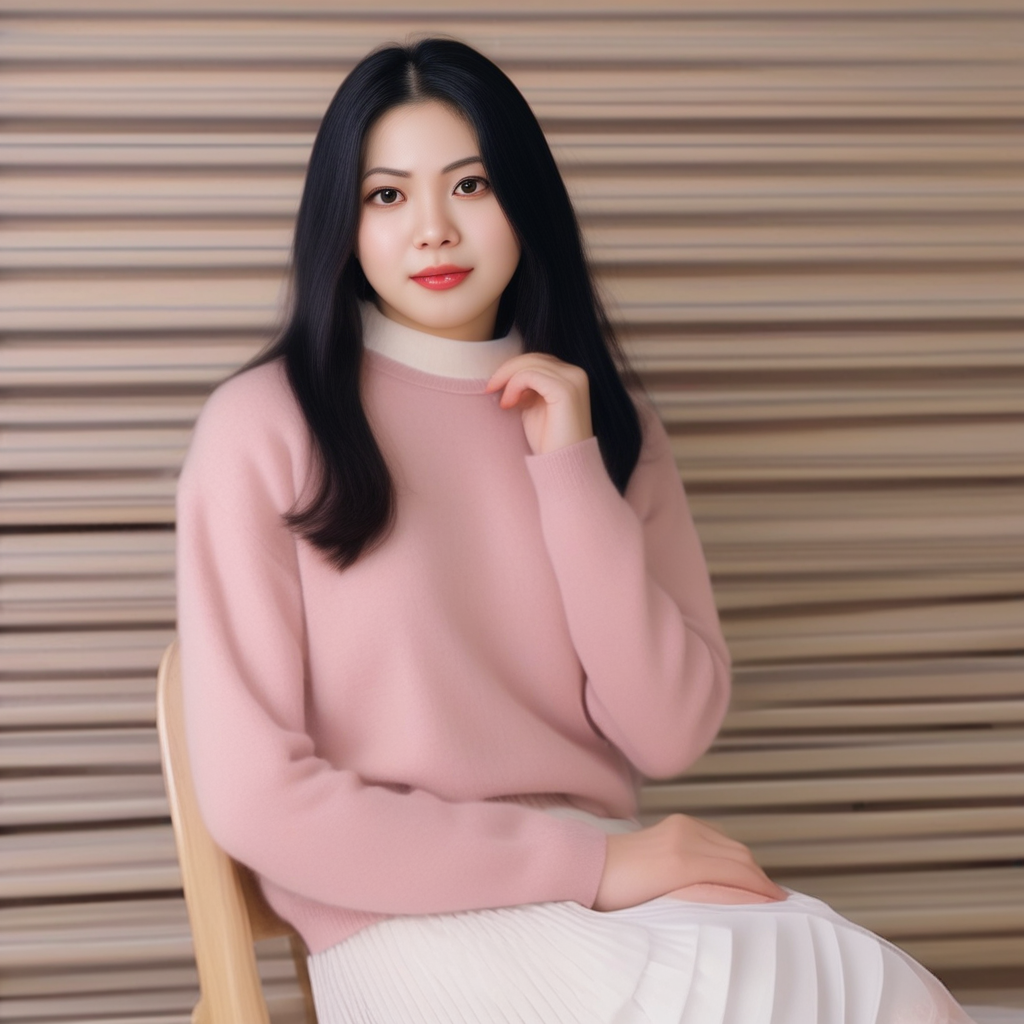

In [18]:
prompt = "a photo of a (srcy:1.2) woman, round face, long black hair parted down the middle, hair behind shoulders, sitting sideways on wooden chair, white pleated miniskirt, white stockings,brown eyes, pastel pink sweater, 4k,detailed face,detailed skin texture,plain background" # @param

image = pipe(prompt=prompt, num_inference_steps=30).images[0]
image